# Simple Benchmark - How to compare multiple models?

## Imports

In [4]:
import pytest
import os
import pathlib
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

from tot.dataset import Dataset
from tot.models import BayesianRidgeModel, LinearRegressionModel, NeuralProphetModel, ProphetModel, \
    TorchProphetModel, SeasonalNaiveModel, NaiveModel
from tot.experiment import SimpleExperiment, CrossValidationExperiment
from tot.benchmark import SimpleBenchmark, CrossValidationBenchmark

from tot.metrics import ERROR_FUNCTIONS
from neuralprophet import set_random_seed, NeuralProphet, TorchProphet
from neuralprophet.df_utils import split_df, prep_or_copy_df


## Manage data
##### Import dataset

In [5]:
# TODO: datasets should have a simple .load() command
DIR = os.path.abspath('..')
DATA_DIR = os.path.join(DIR, "tests", "test-data")
AIR_FILE = os.path.join(DATA_DIR, "air_passengers.csv")
ENERGY_FILE = os.path.join(DATA_DIR, "tutorial01-full-energy-data.csv")

##### Inspect dataset

<AxesSubplot: xlabel='ds'>

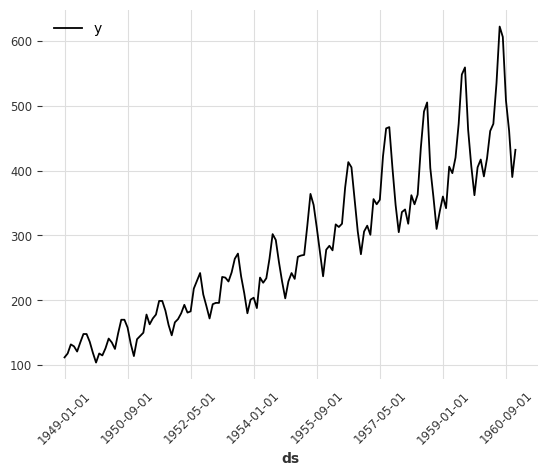

In [6]:
air_passengers_df = pd.read_csv(AIR_FILE)
air_passengers_df.plot(x='ds', rot=45)

## Set up simple benchmark with AirPassenger data and five different models
We offer a template for a simple benchmark that is filled with the selected dataset(s), model(s) and model parameters.

First, we select the AirPassenger dataset. Therefore, we input the ´´air_passengers_df´´, the name, the data`s frequency.
Ideally, we add all available information about the dataset, in this case as well the ´´seasonality_mode="multiplicative"´´.

In [7]:
dataset_list = [
    Dataset(df=air_passengers_df, name="air_passengers", freq="MS"),
]

#### Manage models

##### Configure common hyperparameters
We want to compare the selected models on te same prediction task. We define N_FORECAST = 3 for all models. Besides
Prophet only offers 1-step predictions. For
NeuralProphet and Prophet, we commonly set "seasonality_mode": "multiplicative". For all NeuralProphet models we set a
common learning rate and number of epochs.

In [8]:
N_FORECASTS = 3
SEASONALITY_MODE = 'multiplicative'
LR = 0.01
EPOCHS = 50

##### Select models and individual model parameters
In total, we compare 5 different models. For each model we define the relevant hyperparameters. The NeuralProphet model
we compare among 3 different configurations. The most simple configuration of NeuralProphet has no autoregression enabled.
The 2nd configuration has autoregression enabled. The 3rd configuration has a pre-defined number of hidden layers and
hidden dimension. For the Prophet model we implement the test-of-time version as well as the offered wrapper of neuralprophet

In [9]:
model_classes_and_params = [
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 9,  "seasonality_mode": SEASONALITY_MODE,
                          "yearly_seasonality": True, "num_hidden_layers": 1, "d_hidden": 64,
                          "learning_rate": LR, "epochs": EPOCHS }),
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 9,  "seasonality_mode": SEASONALITY_MODE,
                          "yearly_seasonality": True,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (NeuralProphetModel, {"n_forecasts": 1, "seasonality_mode": SEASONALITY_MODE,
                          "yearly_seasonality": True,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (ProphetModel, {"seasonality_mode": "multiplicative"}),
    (TorchProphetModel, {"seasonality_mode": "multiplicative", 'interval_width': 0}),
    (SeasonalNaiveModel, {"n_forecasts": N_FORECASTS, "season_length": 12}),
    (NaiveModel, {"n_forecasts": N_FORECASTS}),
    (LinearRegressionModel, {"n_forecasts": N_FORECASTS, "n_lags": 9, "output_chunk_length": 3}),
]

#### Configure the benchmark
Now, we add the dataset and the configured models and instansiate a benchmark. We select turn return the MAPE error metric.
Further error metrics can be added on demand. Further, we select to test on 40% of the data.

In [10]:
# set_random_seed(42)
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params,
    datasets=dataset_list,
    metrics=["MAPE"],
    test_percentage=40,
)

Besides the SimpleBenchmark class we have further templates for pre-configured benchmarks as well as to manually
configure a benchmark.

#### Run the benchmark
We simply execute the benchmark by calling benchmark.run() and print the train and test results.

In [2]:
# Important to set seed for reproducibility
results_train, results_test = benchmark.run()

In [3]:
results_test

## Let`s have a look at the individual results
First, we need to manually split the train and test data.


In [12]:
def _tot_split_df(df, n_lags, test_percentage):
    """Splits timeseries df into train and validation sets.
    Additionally, prevents overbleed of targets. Overbleed of inputs can be configured.
    In case of global modeling the split could be either local or global.

    Parameters
    ----------
        df : pd.DataFrame
            data to be splitted
        n_lags : int
            identical to NeuralProphet
        n_forecasts : int
            identical to NeuralProphet
        test_percentage : float, int
            fraction (0,1) of data to use for holdout validation set, or number of validation samples >1
        inputs_overbleed : bool
            Whether to allow last training targets to be first validation inputs (never targets)

    Returns
    -------
        pd.DataFrame
            training data
        pd.DataFrame
            validation data
    """
    # Receives df with single ID column
    assert len(df["ID"].unique()) == 1
    n_samples = len(df)
    if 0.0 < test_percentage < 1.0:
        n_valid = max(1, int(n_samples * test_percentage))
    else:
        assert test_percentage >= 1
        assert type(test_percentage) == int
        n_valid = test_percentage
    n_train = n_samples - n_valid
    assert n_train >= 1

    split_idx_train = n_train
    split_idx_val = split_idx_train+1 if n_lags==0 else split_idx_train-(n_lags+1)+1
    df_train = df.copy(deep=True).iloc[:split_idx_train].reset_index(drop=True)
    df_val = df.copy(deep=True).iloc[split_idx_val:].reset_index(drop=True)
    return df_train, df_val

In [13]:
def tot_split_df(df, n_lags, test_percentage=0.25, local_split=False):
    """Splits timeseries df into train and validation sets.

    Prevents overbleed of targets. Overbleed of inputs can be configured.
    In case of global modeling the split could be either local or global.

    Parameters
    ----------
        df : pd.DataFrame
            dataframe containing column ``ds``, ``y``, and optionally``ID`` with all data
        n_lags : int
            identical to NeuralProphet
        n_forecasts : int
            identical to NeuralProphet
        test_percentage : float, int
            fraction (0,1) of data to use for holdout validation set, or number of validation samples >1
        inputs_overbleed : bool
            Whether to allow last training targets to be first validation inputs (never targets)
        local_split : bool
            when set to true, each episode from a  dataframes will be split locally

    Returns
    -------
        pd.DataFrame
            training data
        pd.DataFrame
            validation data
    """
    df, _, _, _ = prep_or_copy_df(df)
    df_train = pd.DataFrame()
    df_val = pd.DataFrame()
    if local_split:
        for df_name, df_i in df.groupby("ID"):
            df_t, df_v = _tot_split_df(df_i, n_lags, test_percentage)
            df_train = pd.concat((df_train, df_t.copy(deep=True)), ignore_index=True)
            df_val = pd.concat((df_val, df_v.copy(deep=True)), ignore_index=True)
    else:
        if len(df["ID"].unique()) == 1:
            for df_name, df_i in df.groupby("ID"):
                df_train, df_val = _tot_split_df(df_i, n_lags, test_percentage)

    # df_train and df_val are returned as pd.DataFrames
    return df_train, df_val

In [14]:
df_train_air, df_test_air = tot_split_df(df=air_passengers_df, n_lags=9, test_percentage=0.40, local_split=False)
df_train_air_1step, df_test_air_1step = tot_split_df(df=air_passengers_df, n_lags=0, test_percentage=0.40, local_split=False)

We instantiate the 1st configuration of NeuralProphet with the same hyperparameters as in the benchmark

In [15]:
set_random_seed(42)
model = NeuralProphetModel.model_class(
    n_forecasts=1,
    seasonality_mode=SEASONALITY_MODE,
    yearly_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
)

We fit and predict the model

In [4]:
metrics_train = model.fit(df=df_train_air_1step, freq="MS", minimal=True)
forecast = model.predict(df=df_test_air_1step)

And we calculate the MAPE of our test data to double check.

In [17]:
def calc_MAPE(predictions, truth):
    metric_test_list = []
    predictions = predictions.fillna(value=np.nan)
    n_yhats_test = sum(["yhat" in colname for colname in predictions.columns])
    for x in range(1, n_yhats_test + 1):
        metric_test_list.append(
            ERROR_FUNCTIONS['MAPE'](
                predictions=predictions["yhat{}".format(x)].values,
                truth=truth.iloc[:, 1].values,
            )
        )
    MAPE = np.nanmean(metric_test_list, dtype="float32")
    return MAPE, metric_test_list

In [18]:
MAPE, metric_test_list = calc_MAPE(forecast, df_test_air_1step)
print('metrics list', metric_test_list)
print('MAPE', MAPE)

metrics list [8.967839181423187]
MAPE 8.967839


Let`s print the results. We highlight the 1 step ahead forecast, since the NeuralProphetwithout autoregression
can only create 1 step ahead forecasts.

In [5]:
fig = model.plot(forecast, plotting_backend='matplotlib', forecast_in_focus=1)
fig.show()

#### Let`s try investigate the other models
configuration 2

In [6]:
set_random_seed(42)
model_conf2 = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags= 9,
    seasonality_mode=SEASONALITY_MODE,
    yearly_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train = model_conf2.fit(df=df_train_air, freq="MS", minimal=True)
forecast = model_conf2.predict(df=df_test_air)
MAPE, metric_test_list = calc_MAPE(forecast, df_test_air)
print('metrics list', metric_test_list)
print('MAPE', MAPE)
fig = model_conf2.plot(forecast, plotting_backend='matplotlib', forecast_in_focus=N_FORECASTS)
fig.show()

configuration 3

In [7]:
set_random_seed(42)
model_conf_3 = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags= 9,
    seasonality_mode=SEASONALITY_MODE,
    yearly_seasonality=True,
    num_hidden_layers=1,
    d_hidden=64,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train = model_conf_3.fit(df=df_train_air, freq="MS", minimal=True)
forecast = model_conf_3.predict(df=df_test_air)
MAPE, metric_test_list = calc_MAPE(forecast, df_test_air)
print('metrics list', metric_test_list)
print('MAPE', MAPE)
fig = model_conf_3.plot(forecast, plotting_backend='matplotlib', forecast_in_focus=N_FORECASTS)
fig.show()

TorchProphet

In [8]:
set_random_seed(42)
model_tp = TorchProphetModel.model_class(
    seasonality_mode=SEASONALITY_MODE,
    interval_width=0,
)
metrics_train_tp  = model_tp.fit(df=df_train_air_1step, freq="MS", minimal=True)
forecast_tp  = model_tp.predict(df=df_test_air_1step)
MAPE_tp , metric_test_list_tp  = calc_MAPE(forecast_tp, df_test_air_1step)
print('metrics list', metric_test_list_tp )
print('MAPE', MAPE_tp)
fig = model_tp.plot(forecast_tp , plotting_backend='matplotlib', forecast_in_focus=1)
fig.show()

## Set up simple benchmark with Energy data and the same five different models
First, we select the Energy dataset. Therefore, we input the ´´energy_df´´, the name, the data`s frequency, which is hourly.
Ideally, we add all available information about the dataset.

##### Inspect dataset

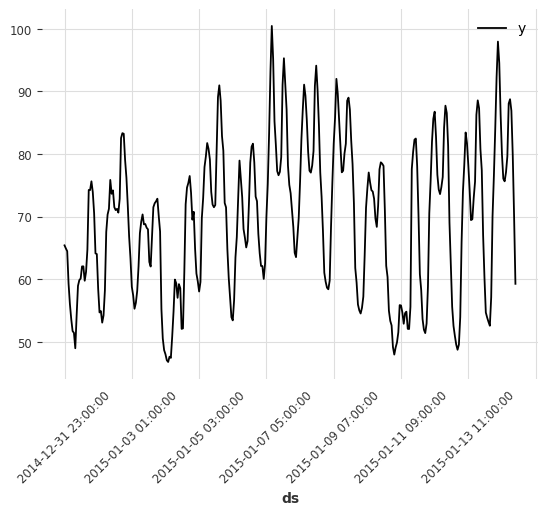

In [23]:
energy_df = pd.read_csv(ENERGY_FILE)
energy_df[0:24*14].plot(x= 'ds', y='y', rot=45)
plt.show()

In [24]:
dataset_list = [
    Dataset(df=energy_df, name="energy", freq="H"),
]

#### Manage models
##### Configure common hyperparameters
We want to compare the selected models on te same prediction task. We define N_FORECAST = 3 for all models. Besides
Prophet only offers 1-step predictions. For
NeuralProphet and Prophet, we commonly set "seasonality_mode": "multiplicative". For all NeuralProphet models we set a
common learning rate and number of epochs.

In [25]:
N_FORECASTS = 3
LR = 0.01
EPOCHS = 20

##### Select models and individual model parameters
In total, we compare 5 different models. For each model we define the relevant hyperparameters. The NeuralProphet model
we compare among 3 different configurations. The most simple configuration of NeuralProphet has no autoregression enabled.
The 2nd configuration has autoregression enabled. The 3rd configuration has a pre-defined number of hidden layers and
hidden dimension. For the Prophet model we implement the test-of-time version as well as the offered wrapper of neuralprophet

In [26]:
model_classes_and_params = [
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 9,
                          "daily_seasonality": True, "num_hidden_layers": 1, "d_hidden": 64,
                          "learning_rate": LR, "epochs": EPOCHS }),
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 9,
                          "daily_seasonality": True,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (NeuralProphetModel, {"n_forecasts": 1,
                          "daily_seasonality": True,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (ProphetModel, {}),
    (TorchProphetModel, {'interval_width': 0}),
    (SeasonalNaiveModel, {"n_forecasts": N_FORECASTS, "season_length": 12}),
    (NaiveModel, {"n_forecasts": N_FORECASTS}),
    (LinearRegressionModel, {"n_forecasts": N_FORECASTS, "n_lags": 9, "output_chunk_length": 3}),
]

#### Configure the benchmark
Now, we add the dataset and the configured models and instanciate a benchmark. We select turn return the MAPE error metric.
Further error metrics can be added on demand. Further, we select to test on 40% of the data.

In [27]:
# set_random_seed(42)
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params,
    datasets=dataset_list,
    metrics=["MAPE"],
    test_percentage=40,
)

Besides the SimpleBenchmark class we have further templates for pre-configured benchmarks as well as to manually
configure a benchmark.

#### Run the benchmark
We simply execute the benchmark by calling benchmark.run() and print the train and test results.

In [9]:
# Important to set seed for reproducibility
results_train, results_test = benchmark.run()
results_test

## Let`s have a look at the individual results
First, we need to manually split the train and test data.

configuration 1

In [29]:
df_train_energy, df_test_energy = tot_split_df(df=energy_df, n_lags=9, test_percentage=0.40, local_split=False)
df_train_energy_1step, df_test_energy_1step = tot_split_df(df=energy_df, n_lags=0, test_percentage=0.40, local_split=False)

We instantiate the 1st configuration of NeuralProphet with the same hyperparameters as in the benchmark

In [30]:
set_random_seed(42)
model_np1 = NeuralProphetModel.model_class(
    n_forecasts=1,
    daily_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
)

We fit and predict the model

In [10]:
metrics_train_np1 = model_np1.fit(df=df_train_energy_1step, freq="H")
forecast_np1 = model_np1.predict(df=df_test_energy_1step)

In [11]:
MAPE_np1, metric_test_list_np1 = calc_MAPE(forecast_np1, df_test_energy_1step)
print('metrics list', metric_test_list_np1)
print('MAPE', MAPE_np1)
fig = model_np1.plot(forecast_np1[-7*24:-1], plotting_backend='plotly', forecast_in_focus=1)
fig.show()

#### Let`s try investigate the other models
configuration 2

In [12]:
set_random_seed(42)
model_np2 = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags= 9,
    daily_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train_np2 = model_np2.fit(df=df_train_energy, freq="H")
forecast_np2 = model_np2.predict(df=df_test_energy)

In [13]:
MAPE_np2, metric_test_list_np2 = calc_MAPE(forecast_np2, df_test_energy)
print('metrics list', metric_test_list_np2)
print('MAPE', MAPE_np2)
fig = model_np2.plot(forecast_np2[-7*24:-1], plotting_backend='plotly', forecast_in_focus=N_FORECASTS)
fig.show()

configuration 3

In [14]:
set_random_seed(42)
model_np3 = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags= 9,
    daily_seasonality=True,
    num_hidden_layers=1,
    d_hidden=64,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train_np3 = model_np3.fit(df=df_train_energy, freq="H")
forecast_np3 = model_np3.predict(df=df_test_energy)

In [15]:
MAPE_np3, metric_test_list_np3 = calc_MAPE(forecast_np3, df_test_energy)
print('metrics list', metric_test_list_np3)
print('MAPE', MAPE_np3)
fig = model_np3.plot(forecast_np3[-7*24:-1], plotting_backend='plotly', forecast_in_focus=N_FORECASTS)
fig.show()


TorchProphet

In [16]:
set_random_seed(42)
model_tp = TorchProphetModel.model_class(
    interval_width=0,
)
metrics_train_tp  = model_tp.fit(df=df_train_energy_1step, freq="MS", minimal=True)
forecast_tp  = model_tp.predict(df=df_test_energy_1step)
MAPE_tp , metric_test_list_tp  = calc_MAPE(forecast_tp, df_test_energy_1step)
print('metrics list', metric_test_list_tp )
print('MAPE', MAPE_tp)
fig = model_tp.plot(forecast_tp[-7*24:-1] , plotting_backend='plotly', forecast_in_focus=1)
fig.show()